# 验证站点数据

# Import packages

In [1]:
# Reading/Writing Data
import os
import glob
import numpy as np
import pandas as pd
import math 
import matplotlib.pyplot as plt

# Pytorch
import torch 
from torch.utils.data import DataLoader, random_split

# Self-Defined Package
from SMAPDataset import SMAPDataset
from SMCNN import SMCNN
from SDLoss import self_defined_loss, ab_physics_loss
from Preprocessing import random_spatial_sequence, collate_insitu_validation

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Some Utility Functions

In [3]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Configurations
`config` contains hyper-parameters for training and the path to save your model.

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 11611801,      # Your seed number, you can pick your lucky number. :)
    'is_train': True,
    'test_batch_size': 1,
    'root': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\AB',
    'model_save_dir': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\AB\\OUTPUT\\MODELS\\CNN'
}

In [5]:
# # Set seed for reproducibility
same_seed(config['seed'])

In [6]:
print(config['root'])
# 创建数据集
insitu_dataset = SMAPDataset(config['root'], insitu_validation=True)
# 创建数据加载器
insitu_loader = DataLoader(insitu_dataset, batch_size=config['test_batch_size'], shuffle=True, collate_fn=collate_insitu_validation)

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB
***************************Load data path******************************
_______________________________2015104_______________________________
_____________________________smap cell: 15_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015104\15.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\TEXTURE\15.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015104\15.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SM\2015104\4.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\INSITU\2015104\4.npy
_____________________________smap cell: 17_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015104\17.npy
D:\1GRADUATED\paper\downscali

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\INSITU\2015187\30.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SM\2015187\22.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\INSITU\2015187\22.npy
_____________________________smap cell: 9_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015187\9.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\TEXTURE\9.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015187\9.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SM\2015187\55.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\INSITU\2015187\55.npy
_______________________________2015194_______________________________
_____________________________smap cel

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015282\18.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SM\2015282\31.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\INSITU\2015282\31.npy
_____________________________smap cell: 2_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015282\2.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\TEXTURE\2.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015282\2.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SM\2015282\2.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\INSITU\2015282\2.npy
_____________________________smap cell: 20_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_m

In [7]:
print(len(insitu_dataset))

493


In [8]:
def tester(test_loader, model, config, device):
    relu = torch.nn.ReLU(inplace=True)
#     criterion = ab_physics_loss
    model.eval()
    pred_pkg = {'date':[], 'smapid':[], 'insituid':[], 'a': [], 'b': [], 'smap': [], 'insitu_ati': [], 'insitu_sm':[], 'pred_sm':[]}
    pred_list = np.zeros((len(test_loader), 2))
    for i, data_pkg in enumerate(test_loader):
        x = data_pkg['processed_data']
        with torch.no_grad():
            pred = model(x)
            relu(pred[:, 0])
#             x, pred = x.to(device), pred.to(device)  
        date = data_pkg['meta_data'][0]['date']
        smapid = data_pkg['meta_data'][0]['smapid']
        insituid_list = data_pkg['meta_data'][0]['insituid']
        for i in range(len(insituid_list)):
            # 去点站点sm为零的数据
            if(data_pkg['label_data']['insitu_sm'][0][i][0]<=0):
                continue
            pred_pkg['date'].append(date)
            pred_pkg['smapid'].append(smapid)
            pred_pkg['insituid'].append(insituid_list[i])
            pred_pkg['a'].append(pred[0][0].item())
            pred_pkg['b'].append(pred[0][1].item())
            pred_pkg['smap'].append(data_pkg['label_data']['smap'][0][0])
            pred_pkg['insitu_ati'].append(data_pkg['label_data']['insitu_ati'][0][i][0])
            pred_pkg['insitu_sm'].append(data_pkg['label_data']['insitu_sm'][0][i][0])
            pred_sm = pred[0][0].item()*data_pkg['label_data']['insitu_ati'][0][i][0] + pred[0][1].item()
            pred_pkg['pred_sm'].append(pred_sm)
            
    return pred_pkg

In [40]:
param_path = os.path.join(config['model_save_dir'], 'base.ckpt' )
print(insitu_dataset.get_input_shape(0))
model = SMCNN(input_channel=insitu_dataset.get_input_shape(0)[2]).to(device)
print(model)
model.load_state_dict(torch.load(param_path))
pred_pkg = tester(insitu_loader, model, config, device) 

(11, 11, 19)
SMCNN(
  (cnn): Sequential(
    (0): Conv2d(19, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3872, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=2, bias=True)
  )
)


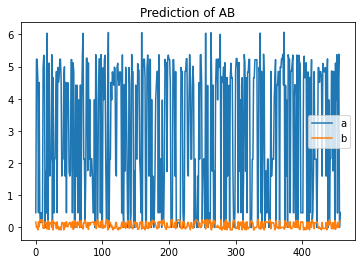

In [10]:
plt.plot(pred_pkg['a'], label='a')
plt.plot(pred_pkg['b'], label='b')
# 添加标题和标签
plt.title('Prediction of AB')
# plt.xlabel('Index of Model')
plt.legend()
plt.show()

In [11]:
df = pd.DataFrame(pred_pkg)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458 entries, 0 to 457
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        458 non-null    object 
 1   smapid      458 non-null    object 
 2   insituid    458 non-null    object 
 3   a           458 non-null    float64
 4   b           458 non-null    float64
 5   smap        458 non-null    float64
 6   insitu_ati  458 non-null    float64
 7   insitu_sm   458 non-null    float64
 8   pred_sm     458 non-null    float64
dtypes: float64(6), object(3)
memory usage: 32.3+ KB


In [12]:
import random

start = 0
end = df.shape[0]-1
num_samples = 1

sample = np.random.randint(start, end+1, size=num_samples)
print(sample)

[107]


In [13]:
df.iloc[sample]

,date,smapid,insituid,a,b,smap,insitu_ati,insitu_sm,pred_sm
107,2015288,26,25,0.154119,0.238438,0.218191,0.042131,0.1965,0.244931


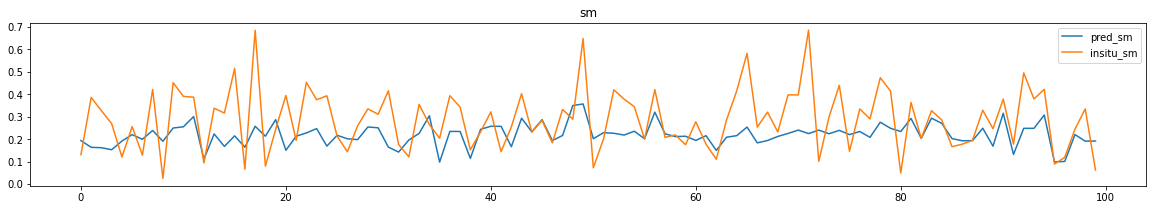

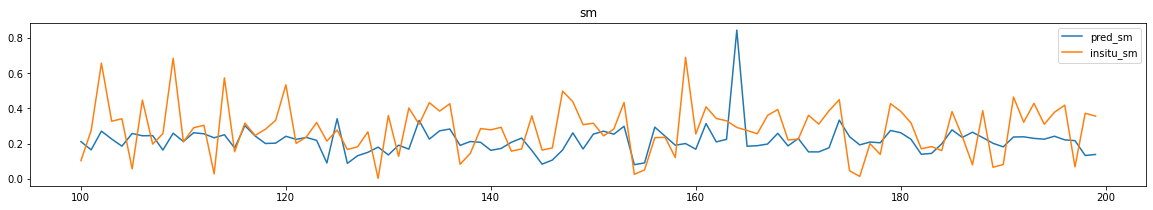

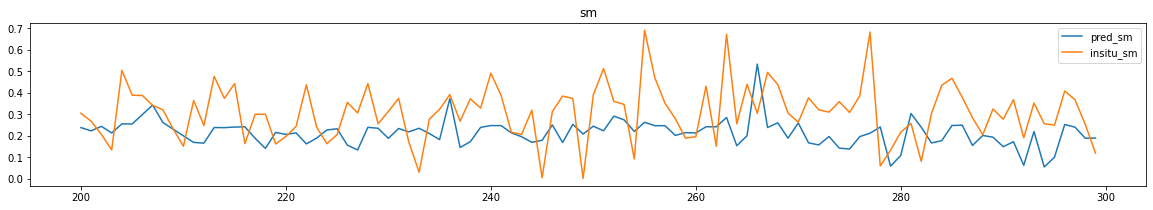

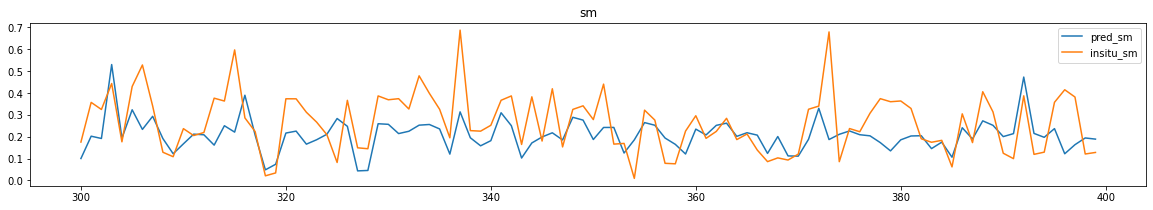

In [41]:
for i in range(4):
    plt.figure(figsize=(20,3))
    plt.plot(df['pred_sm'].iloc[i*100:(i+1)*100], label='pred_sm')
    plt.plot(df['insitu_sm'].iloc[i*100:(i+1)*100], label='insitu_sm')
    # 添加标题和标签
    plt.title('sm')
    plt.legend()
    plt.savefig(os.path.join(config['model_save_dir'], 'sm for all waternet part '+str(i)), dpi=300, bbox_inches='tight')
    plt.show()

# 总体R和RMSE

In [15]:
corr = df['pred_sm'].corr(df['insitu_sm'])
print(corr)

0.3493704366887938


In [16]:
from sklearn.metrics import mean_squared_error
# calculate the mean squared error (MSE)
mse = mean_squared_error(df['insitu_sm'], df['pred_sm'])

# calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)
print(rmse)

0.14606461299635062


# 站点R和RMSE

In [17]:
print(df['insituid'])

0      37
1      11
2      42
3      55
4      37
       ..
453     4
454     6
455    10
456    27
457    37
Name: insituid, Length: 458, dtype: object


In [18]:
insitu_grouped = df.groupby(['insituid'])

In [20]:
def calc_rmse(group):
    return np.sqrt(mean_squared_error(group['insitu_sm'], group['pred_sm']))

def calc_corr(group):
    return group.corr().iloc[0, 1]

In [44]:
insitu_rmse = insitu_grouped.apply(calc_rmse)
print(insitu_rmse)

insituid
1     0.177623
10    0.154604
11    0.157655
12    0.224524
16    0.106250
18    0.119483
2     0.185034
22    0.065079
25    0.139859
27    0.095513
30    0.060370
31    0.088788
32    0.070743
33    0.044529
35    0.128960
37    0.087727
4     0.064493
40    0.219846
42    0.116275
5     0.192554
52    0.082475
53    0.441228
54    0.059961
55    0.143254
6     0.112237
dtype: float64


(14, 9)
0.1776225453075978


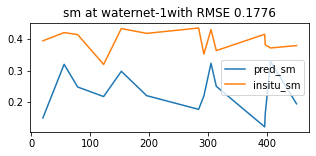

(24, 9)
0.15460378139261716


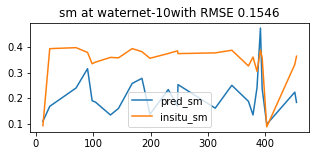

(20, 9)
0.15765475465734777


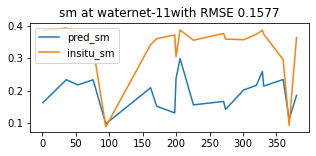

(22, 9)
0.22452383814154045


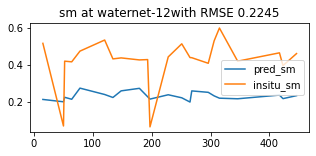

(2, 9)
0.1062503979576016


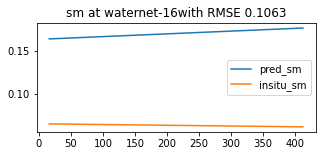

(26, 9)
0.11948301688809519


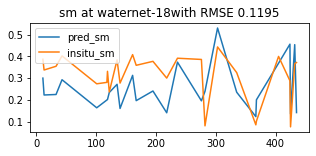

(20, 9)
0.18503352367008932


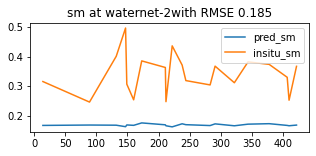

(26, 9)
0.06507867554115886


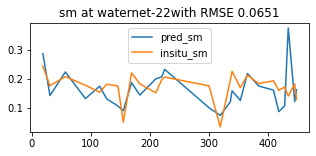

(21, 9)
0.1398591610337825


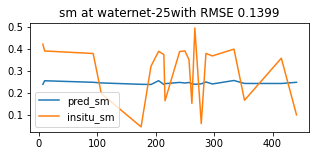

(13, 9)
0.09551307386091733


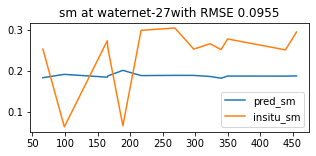

(14, 9)
0.06037016720189467


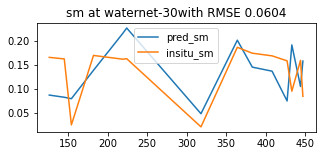

(24, 9)
0.08878802567818052


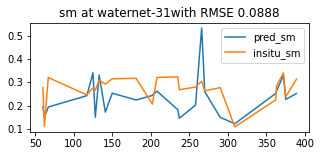

(22, 9)
0.07074346185783821


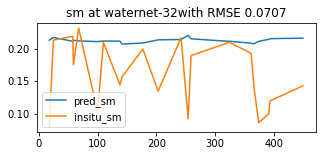

(2, 9)
0.044528539742595644


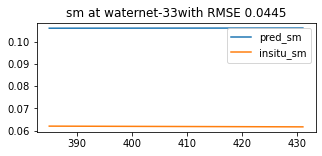

(20, 9)
0.1289595326324976


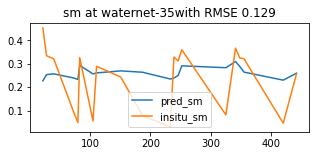

(15, 9)
0.08772703702734669


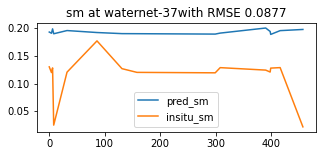

(26, 9)
0.06449262297941896


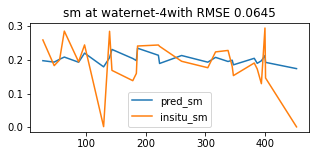

(14, 9)
0.21984602208309292


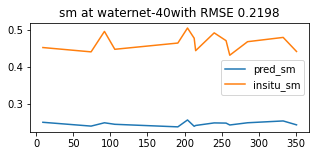

(22, 9)
0.11627491492918053


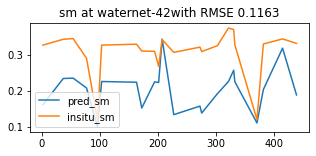

(24, 9)
0.19255417676045783


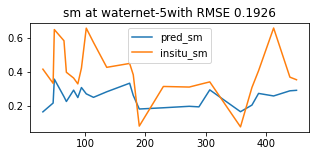

(19, 9)
0.08247535480854801


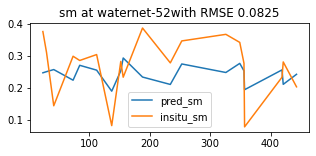

(9, 9)
0.44122776003140113


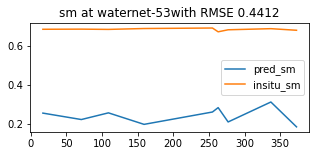

(21, 9)
0.05996088973258862


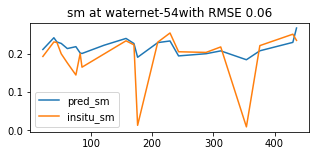

(28, 9)
0.14325420059088884


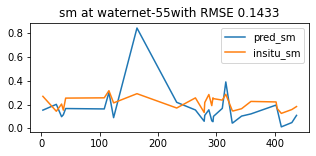

(10, 9)
0.11223720258992544


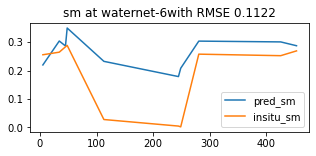

In [45]:
i = 0
for name, group in insitu_grouped:
    print(group.shape)
    print(insitu_rmse.iloc[i])
    plt.figure(figsize=(5,2))
    plt.plot(group['pred_sm'], label='pred_sm')
    plt.plot(group['insitu_sm'], label='insitu_sm')
    # 添加标题和标签
    plt.title('sm at waternet-'+ name + 'with RMSE ' + str(np.round(insitu_rmse.iloc[i], 4)))
    plt.legend()
    plt.savefig(os.path.join(config['model_save_dir'], 'sm at waternet-'+ name + 'with RMSE ' + str(np.round(insitu_rmse.iloc[i], 4)) + '.png'), dpi=300, bbox_inches='tight')
    plt.show()
    i+=1

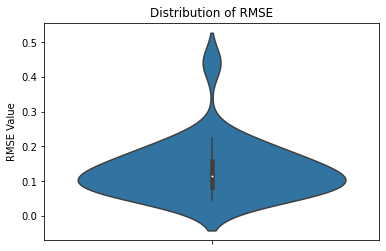

In [22]:
# 将数据转换为DataFrame格式
df_rmse = pd.DataFrame(insitu_rmse, columns=['RMSE'])

# 绘制小提琴图
sns.violinplot(y='RMSE', data=df_rmse, scale='count')
# sns.barplot(y='MSE', data=df)
# 添加标题和标签
plt.title('Distribution of RMSE')
# plt.xlabel('Index of Model')
plt.ylabel('RMSE Value')

# 显示图形
# plt.savefig(config['root'] + 'OUTPUT\\IMAGE\\DATAVISUALIZE\\CNN\\' + str(config['seed']) + '\\' + 'MSEDistribution.png', dpi=600, transparent=False)    
plt.show()

In [23]:
insitu_corr = insitu_grouped[['pred_sm', 'insitu_sm']].apply(calc_corr)
print(insitu_corr)

insituid
1     0.128259
10    0.468226
11    0.540858
12    0.296473
16   -1.000000
18    0.488431
2     0.008097
22    0.379851
25    0.250769
27   -0.706455
30    0.390282
31    0.397742
32   -0.201977
33   -1.000000
35    0.345120
37   -0.081333
4     0.592381
40    0.608374
42    0.624799
5     0.566001
52    0.449514
53   -0.006007
54    0.655280
55    0.533520
6     0.809929
dtype: float64


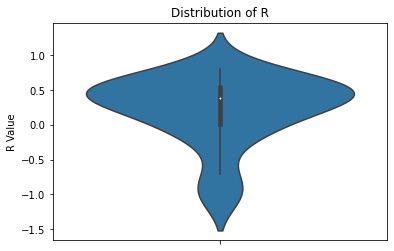

In [24]:
# 将数据转换为DataFrame格式
df_corr = pd.DataFrame(insitu_corr, columns=['R'])

# 绘制小提琴图
sns.violinplot(y='R', data=df_corr, scale='count')
# sns.barplot(y='MSE', data=df)
# 添加标题和标签
plt.title('Distribution of R')
# plt.xlabel('Index of Model')
plt.ylabel('R Value')

# 显示图形
# plt.savefig(config['root'] + 'OUTPUT\\IMAGE\\DATAVISUALIZE\\CNN\\' + str(config['seed']) + '\\' + 'MSEDistribution.png', dpi=600, transparent=False)    
plt.show()